# Lab 2


* It is expected that you work individually and the usual plagarism rules apply.
* Submissions are to be made on canvas. Make sure that you add your student ID in the submission comments.
* The main notebook file you submit should read "Lab[number]_[last name].ipynb", for example "Lab2_Bongers.ipynb". 
* Please make sure your code will run without problems

_You need to fill in everywhere that there is a_ '__TODO__'

Feel free ask any questions during the computer lab sessions, or email the TA.

**The due date for the labs is next Monday at 23:59**

## Part 1: Model 1


In this part of the lab you will plot the prior, posterior and predictive distributions for a set of data that we assume to follow an exponential distribution.

In [1]:
import math
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.datasets

from scipy import integrate

Statsmodels is a Python package for conducting statistical data analyses. It also contains real-world datasets that we can use when experimenting with new methods. Here, we load the heart dataset. Each line indicates the number of days that a patient survived after a heart transplant, together with the age of the patient.

Here you can have a look at the 5 last lines of the data frame.

In [2]:
data_original = statsmodels.datasets.heart.load_pandas().data
data_original.tail()

,survival,censors,age
64,14.0,1.0,40.3
65,167.0,0.0,26.7
66,110.0,0.0,23.7
67,13.0,0.0,28.9
68,1.0,0.0,35.2


This dataset contains censored and uncensored data: a censor of $0$ means that the patient was alive at the end of the study, and thus we don't know the exact survival time. We only know that the patient survived at least the indicated number of days. For simplicity here, we only keep uncensored data (we thereby introduce a bias toward patients that did not survive very long after their transplant) and we store it in an array 'data_full'. We also divided each number by 365, so the period of time that a patient survived a heart transplant is given in years.

In [3]:
data_original = data_original[data_original.censors == 1]
survival = data_original.survival
survival=np.array(survival)
data_full=survival/365

In the array 'data', we store the first 'p' elements of 'data_complete'. First, we let 'p' be $45$. The idea is we are going to predict the distribution of the survival time only using 'p' data (while the full dataset contains $69$ data) and later, we can play with the value of 'p' and see how many data are actually needed to have a satisfying prediction. We also plot the data. 

0.7264187866927594


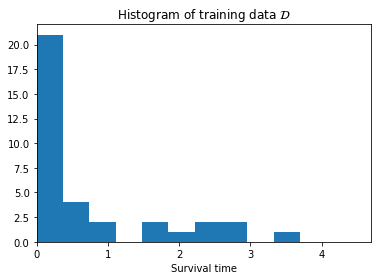

In [4]:
# restricting the data to p elements
p=35
data=data_full[:p]
N=len(data)

# plotting the data
datamin = np.amin(data)
datamax = np.amax(data)
absmax = np.maximum(np.abs(datamin), np.abs(datamax)) + 1
plt.figure(0)
plt.hist(data, bins=10)
plt.xlim(0, absmax)
plt.xlabel('Survival time')
plt.title('Histogram of training data $\mathcal{D}$')

print(np.mean(data))

We assume that the data follows an exponential distribution with parameter $\lambda$. That is,
$$
p(x|\lambda)=\lambda e^{-\lambda x}
$$
We also suppose that the prior distribution for $\lambda$ is a Gamma distribution with parameters $\alpha$ and $\beta$
$$
p(\lambda)= \frac{1}{Z(\alpha,\beta)} \lambda^{\alpha-1} e^{-\beta \lambda}
$$
Initially, we suppose $\alpha=2$ and $\beta=2$. We start by plotting the prior distribution. The code below plots the function
$$
\lambda^{\alpha-1} e^{-\beta \lambda}
$$
So if we would normalize that function, we would obtain the prior distribution. It is *almost* the prior, the problem being that the area under the graph might not be $1$.

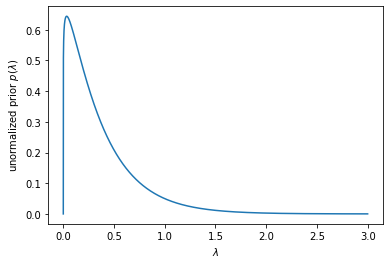

In [5]:
#plotting the prior up to a constant (not normalized)

def gam(x,alpha=1.1,beta=3):
    return x**(alpha-1)*np.exp(-x*beta)

alpha=1.1
beta=3
x=np.linspace(0,3,5000)
plt.plot(x,gam(x))
plt.xlabel('$\lambda$')
plt.ylabel('unormalized prior $p(\lambda)$')
plt.show()

One way from the previous graph to obtain the prior distribution is to define a function `area(func,a,b)` that computes the area under the graph of the function `func` in the interval $[a,b]$. Then we define a function `norm_plot(func,a,b,legend)` which given a function `func` and an interval $[a,b]$, plots the *normalized* graph of `func` in the interval $[a,b]$ and write `legend` as a legend of the graph. You don't have to write the code for `norm_plot(func,a,b,legend)`, but make sure you understand how it works.  

__TODO1__(0.5pt) Define the function `area(func,a,b)`. In order to compute the area under the graph of a function, we use integration. You can use the following built-in function to define  `area(func,a,b)`:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad

Make sure that the output is indeed a scalar.

In [6]:
def area(func,a,b):
    return integrate.quad(func, a, b)[0]

def norm_plot(func,a,b,labelx, labely, legend):
    x=np.linspace(a,b,1000)
    norm_func=func(x)*(1/area(func,0,200))
    plt.xlabel(labelx, fontsize=13)
    plt.ylabel(labely, fontsize=13)
    plt.plot(x,norm_func,label=legend)

__TODO2__(0.5pt) Using the function `norm_plot`, plot the prior distribution in the interval $[0,3]$.

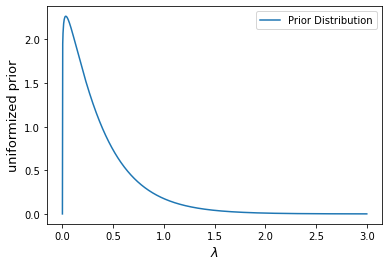

In [7]:
norm_plot(gam, 0, 3, '$\lambda$', 'uniformized prior', 'Prior Distribution')
plt.legend()

plt.show()

The formula for calculating the posterior distribution is 
$$
p(\lambda|\mathcal{D}) = \frac{p(\mathcal{D}|\lambda)p(\lambda)}{p(\mathcal{D})}
$$
where $\mathcal{D}$ is the set of data. Before calculating analytically the posterior distribution for $\lambda$, we will compute by brute force the value of $\lambda$, which we call $\lambda_{\text{brute force}}$, such that $p(\lambda_{\text{brute force}}|\mathcal{D})$ is maximum.   

Given the above equation, we know that
$$
p(\lambda|\mathcal{D}) \propto p(\mathcal{D}|\lambda)p(\lambda)
$$
So we have to find $\lambda_{\text{brute force}}$ such that 
$$
p(\mathcal{D}|\lambda_{\text{brute force}})p(\lambda_{\text{brute force}})
$$
is maximum. 

The idea is that for *enough* $\lambda_1, \dots,\lambda_k$, we compute the array `A`
$$
\begin{bmatrix}
p(\mathcal{D}|\lambda_1)p(\lambda_1) \\
p(\mathcal{D}|\lambda_2)p(\lambda_2) \\
\dots \\
p(\mathcal{D}|\lambda_k)p(\lambda_k)
\end{bmatrix}
$$
and then using the `argmax` function, we find the $\lambda_i$ corresponding to the highest value in `A`. This $\lambda_i$ is our $\lambda_{\text{brute force}}$. 

__TODO3__(2pts) Write a program that outputs the value of the variable `lambda_brute_force`, which should be $\lambda_{\text{brute force}}$. It should follow the steps of the method described above. In order to generate the set $\{ \lambda_1, \dots,\lambda_k \}$, you can use `np.linspace(0,10,k)`. Then define the array `A` as above. Note that $p(\mathcal{D}|\lambda_j)$ refers to an exponential distribution with parameter $\lambda_j$ and $p(\lambda_j)$ refers to a gamma distribution with parameters $\alpha$ and $\beta$ ($\alpha$ and $\beta$ have the same values as before). Finally, using `argmax`, find the $\lambda_i$ corresponding to the highest value of `A`. 

__BONUS__ Write the program without using any `for` loops.

In [8]:
k=50

def brute_force(data, k):
    l = np.linspace(0, 10, k)
    l_exp = l**(len(data)) * np.exp(-l * np.sum(data))
    A = gam(l) * l_exp
    return l[np.argmax(A)]

lambda_brute_force = brute_force(data, k)

print("The brute force estimator of lambda is: ", lambda_brute_force)

The brute force estimator of lambda is:  1.2244897959183674


__TODO4__(0.5pt) Define `alpha_post` and `beta_post` as the parameters of the posterior distribution (the formulas for `alpha_post` and `beta_post` are the answers from the first question of the werkcollege). Plot the posterior distribution using the function `norm_plot`. Note that this time, you cannot use the function `gam` as this function has parameters $\alpha$ and $\beta$ (and the parameters should be `alpha_post` and `beta_post`). So you need to define a new function as an input for `norm_plot`. 

We also plotted for you the prior distribution and the brute force estimator. So you can compare those with the posterior distribution.

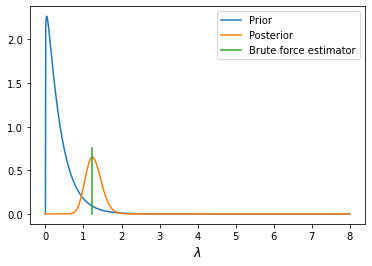

In [9]:
#plotting the posterior distribution, to be filled in
def post_gam(x, alpha=1.1, beta=3):
    alpha_post = len(data) + alpha
    beta_post = sum(data) + beta
    return gam(x, alpha=alpha_post, beta=beta_post)
#plotting the prior distribution, given
norm_plot(gam,0,8,'$\lambda$','','Prior')
norm_plot(post_gam, 0, 8, '$\lambda$','', 'Posterior')
#plotting the brute force operator, given
plt.plot(20*[lambda_brute_force],np.linspace(0,0.76,20),label='Brute force estimator')
plt.legend()
plt.show()

__TODO5__(0.5pt) Try again to run the above program with different values for `p` and for $\alpha$ and $\beta$. Starting from which value of `p`, are we starting to have a stable prediction? (that is, how much data is sufficient to have already a satisfying prediction?) What happens when we start with different values of $\alpha$ and $\beta$? Does it affect a lot the posterior distribution?

Increasing $\alpha$ will change the posterior and the brute force estimator will not be placed well. The same goes for increasing $\beta$. 

__TODO6__(0.5pt) Draw a random sample $S$ of size `M`from the posterior distribution $p(\lambda | \mathcal{D})$. Then, for each value of $\lambda$ in $S$, we draw for you the exponential distribution with parameter $\lambda$. In order to draw the random sample, you can use the following built-in function
https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.gamma.html

In [ ]:
#represent various p(x|lambda) for different lambda ~ p(lambda|data)
M=500
#only this line to be filled in 
# it should be this, but it says alpha_post is not defined
# np.random.gamma(shape=alpha_post,scale=1/beta_post,size=M) 
sample_lambda = np.random.gamma(shape=alpha,scale=1/beta,size=M) 

def expo(x,lam):
    return lam*np.exp(-lam*x)

plt.figure(figsize=(12,8))
for i in range(0,M):
    plt.plot(x,expo(x,sample_lambda[i]),label='$\lambda$=%.3f'%sample_lambda[i], \
             color='b', alpha=0.01)    

plt.xlabel('Survival time: $x$', fontsize=15)
plt.ylabel('$p(x | \lambda)$', fontsize=15)
plt.xlim(0,3)
plt.ylim(0,2)
plt.show()

We compute now the maximum a posteriori (MAP) estimator of $\lambda$, which is the mode of the posterior distribution. In case of a gamma distribution with parameters $\alpha$ and $\beta$, the mode is given by
$$
\frac{\alpha-1}{\beta}
$$

__TODO7__(0.5pt) Compute the MAP estimator  $\lambda_{MAP}$ of $\lambda$. Compute also the maximum likelihood estimator $\lambda_{ML}$ of $\lambda$ (recall that it is equal to $\frac{N}{\sum_i x_i}$, where $\{ x_1, \dots, x_n\}$ is the set of `data`). Then plot the exponential distribution with parameter $\lambda_{MAP}$ and the exponential distribution with parameter $\lambda_{ML}$. How do the two estimators compare to each other? And how do they compare with the brute force estimator?

In [ ]:
#compute the MAP estimator of lambda using the theoretical formula, to be filled in
# weet niet zeker of de haakjes in de noemer kloppen
lambda_MAP = (alpha + len(data) - 1)/(beta + sum(data))

print('The maximum a posteriori estimate of lambda is: ',lambda_MAP)
plt.xlabel('Survival time:$x$')
plt.plot(x,expo(x,lambda_MAP), label='$p(x|\lambda_{MAP})$')

#compute the ML estimator of lambda, to be filled in
lambda_ML = len(data)/sum(data)

print('The maximum likelihood estimator of lambda is: ',lambda_ML)
plt.plot(x,expo(x,lambda_ML),label='$p(x|\lambda_{ML})$')

#print again the brute force estimator, given
print('The brute force estimator of lambda is: ',lambda_brute_force)
plt.plot(x,expo(x,lambda_brute_force),label='$p(x|\lambda_{\mathit{brute force}})$')
plt.legend()
plt.show()

Finally we plot the predictive distribution. It is basically the distribution for future predicted data based on the data we have been given. So the posterior predictive distribution can be used to predict new data values. In the case of an exponential distribution for the data and a prior which is a gamma distribution, the predictive distribution is given by
$$
\frac{\alpha'(\beta')^{\alpha'}}{(\beta'+x)^{\alpha'+1}}
$$
where $\alpha'$ and $\beta'$ are the parameters of the posterior distribution. 

__TODO8__(0.5pt) Plot the predictive distribution.

In [ ]:
#compute the distributive and compare with p(x|lambda_MAP), given
plt.xlabel('Survival time:$x$')
plt.plot(x,expo(x,lambda_MAP),label='$p(x|\lambda_{MAP})$')

#compute the predictive distribution, to be filled in
# volgens mij haal ik hier de data door elkaar
alpha_post = len(data) + alpha
beta_post = sum(data) + beta
predictive_dist = (alpha_post*(beta_post**alpha_post))/((beta_post + data)**(alpha_post + 1))
plt.plot(range(len(data)), predictive_dist,label='MAP $\lambda$')
plt.legend()
plt.show()

## Part 2: Model 2

We will now use the same data but a different model. That will help us to see the impact of choosing a less suitable distribution for the variable $x$.  In this second model, we assume that our random variable $x$ of the survival time (in years) follows a gaussian distribution $p(x|\mu)$ with unknown mean $\mu$ and standard deviation $1$. Our unknown parameter is now $\mu$ and we assume a prior on $\mu$ that is a gaussian with mean $\mu_0 =1$ and standard deviation $\sigma_0 =1$. 

__TODO9__(0.5pt) Plot the prior distribution of $\mu$. You can use the following built-in function
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

In [ ]:
import scipy as sc

x = np.linspace(-2, 4, 100)
distribution = sc.stats.norm(loc=1, scale=1)
plt.plot(x, distribution.pdf(x))
plt.show()

Given the dataset ``data`` of size $N$, we want to update the prior distribution of the unknown parameter $\mu$ and compute the posterior. We can compute analytically the posterior when the distribution is a gaussian with known standard deviation, and the prior is also a gaussian. You can even find the most general formula for the posterior in wikipedia https://en.wikipedia.org/wiki/Conjugate_prior (see the table of conjugate distributions and look at the line 'normal with known variance')

Here, we give you directly the formula for the posterior, so you don't have to work it out analytically like we did for Model 1. The posterior is a gaussian distribution with mean 
$$
\mu_{post} = \frac{1}{N+1} (1+\sum_{i=1}^N x_i)
$$
and standard deviation
$$
\sigma_{post} = \sqrt{\frac{1}{N+1}}
$$

__TODO10__(0.5pt) Plot the posterior distribution of $\mu$. 

In [ ]:
u_post = 1./(len(data) + 1.) * (1. + sum(data))
s_post = np.sqrt(1./(len(data) + 1.))
x = np.linspace((u_post - (3 * s_post)), (u_post + (3 * s_post)), 100)
distribution = sc.stats.norm(loc=u_post, scale=s_post)
plt.plot(x, distribution.pdf(x))
plt.show()

Now to have a more intuitive idea of the posterior, we will again draw a large sample of values of $\mu$ from the posterior distribution and for each of those values, we draw the corresponding distribution $p(x|\mu)$.

__TODO11__(0.5pt) Draw a random sample $S$ of size `M`from the posterior distribution $p(\mu | \mathcal{D})$. In order to draw the random sample, you can use the following built-in function https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html

In [ ]:
#visualize the posterior
#represent various p(x|mu) for different mu ~ p(mu|data)
M=500
#only this line to be filled in 
sample_mu = np.random.normal(loc=u_post, scale=s_post, size=M)
x = np.linspace(0,3,5000)
#def expo(x,lam):
#    return lam*np.exp(-lam*x)

plt.figure(figsize=(12,8))
for i in range(0,M):
    plt.plot(x,st.norm.pdf(x,sample_mu[i]), color='b', alpha=0.01)    

plt.xlabel('Survival time: $x$', fontsize=15)
plt.ylabel('$p(x | \lambda)$', fontsize=15)
plt.xlim(0,3)
plt.ylim(0,0.5)
plt.show()

Finally we plot the predictive distribution. You can again find the most general form of the predictive distribution (for a gaussian with known variance, and a gaussian prior) on the same wikipedia page. In our simplified case, the predictive distribution is a gaussian with mean
$$
\mu_{pred} = \mu_{post}
$$
and standard deviation
$$
\sigma_{pred} = \sqrt{\sigma^2_{post} +1}
$$

__TODO12__(0.5pt) Plot the predictive distribution.

In [ ]:
mu_pred = u_post
sigma_pred = np.sqrt(s_post**2 + 1)
# linspace vanaf 0 is misschien beter
x = np.linspace((mu_pred - (3 * sigma_pred)), (mu_pred + (3 * sigma_pred)), 100)
distribution = sc.stats.norm(loc=mu_pred, scale=sigma_pred)
plt.plot(x, distribution.pdf(x))
plt.show()

## Part 3: Comparing the 2 models

First we plot the predictives distributions obtained from the two models.

In [ ]:
#plotting the 2 predictive distributions
y=st.norm.pdf(x,mu_pred,sigma_pred)
plt.plot(x,y,label='predictive distribution with the gaussian assumption')
plt.plot(x,(alpha_post * (beta_post)**alpha_post) /(beta_post+x)**(alpha_post+1),\
         label='predictive distribution with the exponential assumption')
plt.xlabel('Survival time: $x$', fontsize=15)
plt.legend()
plt.show()

The two predictive distributions look very different. 

__TODO13__(0.5pt) Intuitively, which model do you think is better? Why?

The exponential model looks better, it gives more information since the gaussian is almost a straight line. Maybe if we compute it on a logaritmic scale it would be a better to judge what model is better.

But how can we compare more formally the two predictive distributions? Remember that we only used the first `p` values of our data set. So we used those first `p` values to build our two models and now, whatever values we did not use, we can use them as test data in order to test the quality of our models. 

Given the values $y_1, \dots, y_K$ in our test data set, we can define the log-likelihood of the test data for a predictive distribution $p^\star$ as
$$
\sum_{i=1}^K \ln p^\star(y_i)
$$
If our predictive distribution $p^\star$ is a good model, then the probabilities $p^\star(y_i)$ should be high. So if the quantity
$$
\sum_{i=1}^K \ln p^\star(y_i)
$$
is high, this indicates that our predictive distribution is a suitable distribution.

Note. Why do we use $\sum_{i=1}^K \ln p^\star(y_i)$ instead of $\prod_{i=1}^N p^\star(y_i)$? Or why do we use the log of the likelihood instead of the likelihood itself? The values $p^\star(y_i)$ can be values close to $0$. So if we multiply a lot of small probabilities, due to the limitations of floating point precision, the computer might return a value with a relatively high imprecision.

__TODO14__(1pt) Compute the log-likelihood of the test data for the predictive distribution of model 1 and the log-likelihood of the test data for the predictive distribution of model 2. Which one is higher? Which model is better then?

In [ ]:
# dit is totaal niet af
data_test = data_full[p:]
p_dis_y_gauss = sum(np.log(y))
p_dis_y_exp = sum(np.log(predictive_dist))

print('log gauss:', p_dis_y_gauss)
print('log exp:', p_dis_y_exp)